Running with degree 1
shape of transformed feature space: (569, 30)
shape of self.weights: (31,)
shape of X_test: (69, 31)


/var/folders/mr/334gy9_d1v5d4n8spjcbw2m40000gn/T/ipykernel_3776/2840901392.py:114: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Running with degree 2
shape of transformed feature space: (569, 495)
shape of self.weights: (496,)
shape of X_test: (69, 496)


/var/folders/mr/334gy9_d1v5d4n8spjcbw2m40000gn/T/ipykernel_3776/2840901392.py:114: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Running with degree 3
shape of transformed feature space: (569, 5455)
shape of self.weights: (5456,)
shape of X_test: (69, 5456)


/var/folders/mr/334gy9_d1v5d4n8spjcbw2m40000gn/T/ipykernel_3776/2840901392.py:114: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


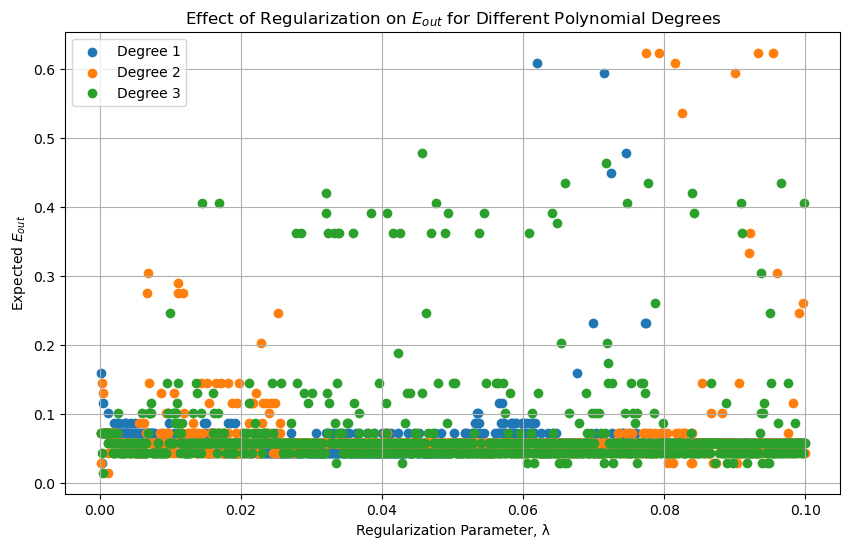

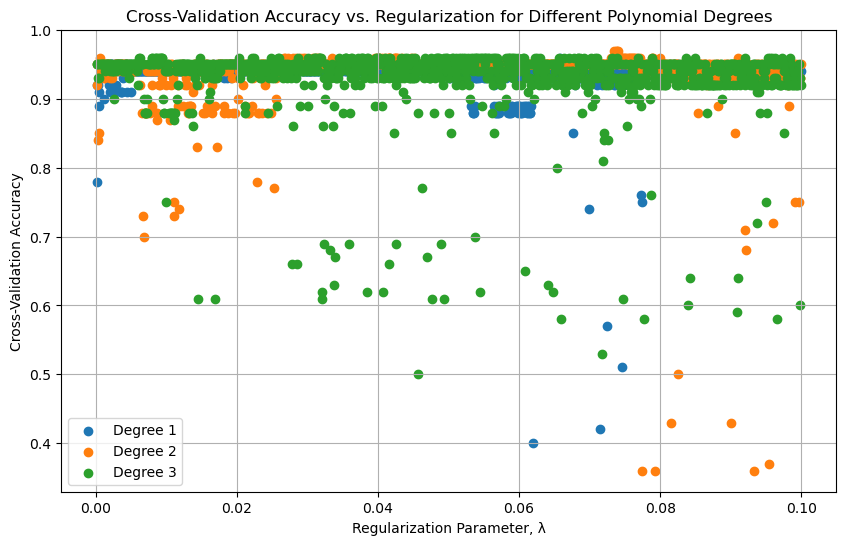


Run completed and combined visualizations generated.


In [2]:
import numpy as np
from numpy.linalg import pinv
import matplotlib.pyplot as plt

from sklearn import datasets 
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import PolynomialFeatures

import pandas as pd
import seaborn as sns

###################
# preprocess data
###################

class DataHandler:
    def __init__(self, 
                 degree_transform: int=2, 
                 kfold_val: int=5, 
                 random_state: int=512):

        self.data = None
        self.df = None
        self.transformed_data = None
        self.targets = None
        self.weights = None
        self.X_train = None
        self.y_train = None
        self.X_val = None
        self.y_val = None
        self.X_test = None
        self.y_test = None
        self.degree_transform = degree_transform
        self.val_size = 1 / kfold_val 
        self.random_state = random_state

    def preprocess(self):
        self.read_in_data()
        self.poly_transform()
        self.init_weights()
        self.separate_test()
        self.create_train_val()

    def read_in_data(self):
        # grad the dataset from sklearn datasets
        in_data = datasets.load_breast_cancer()
        # store features and data points (569 data points X 30 features)
        self.df = pd.DataFrame(in_data.data, columns=in_data.feature_names)
        # store data in array
        self.data = self.df.values
        # store binary diagnoses for 569 data points (0=malignant, 1=benign)
        self.targets = in_data['target']
   
    def poly_transform(self):
        # Create the PolynomialFeatures transformer
        poly = PolynomialFeatures(degree=self.degree_transform, include_bias=False)
        # Transform the data
        self.transformed_data = poly.fit_transform(self.data)
        # Print the shape of the transformed feature space
        print(f'shape of transformed feature space: {self.transformed_data.shape}')  # Output will be (100, 495)
    
    def init_weights(self):
        # add bias term x0=1 to the data
        self.transformed_data = np.column_stack((np.ones(self.transformed_data.shape[0]), self.transformed_data))
        # initialize weights using linear regression
        X_dag = pinv(self.transformed_data)
        self.weights = np.matmul(X_dag, self.targets)
        print(f'shape of self.weights: {self.weights.shape}')
    
        expected_shape = (self.transformed_data.shape[1],)
    
        # Check the shape of the result
        if self.weights.shape != expected_shape:
            raise ValueError(f"Output has shape {self.weights.shape}, but expected shape is {expected_shape}.")
    
    def separate_test(self, num_test_elems: int=69):
        if self.random_state is not None:
            np.random.seed(self.random_state)
            
        num_remove = num_test_elems
        # store indices for removal from data and use as test set
        remove_indices = np.random.choice(np.arange(self.transformed_data.shape[0]), size=num_remove, replace=False)
        self.X_test = self.transformed_data[remove_indices, :]   
        self.y_test = self.targets[remove_indices]   
        print(f'shape of X_test: {self.X_test.shape}')
        
        # remove the test set from the training data
        self.transformed_data = np.delete(self.transformed_data, remove_indices, axis=0)   
        self.targets = np.delete(self.targets, remove_indices, axis=0)  
    
    def create_train_val(self):
        if self.random_state is not None:
            np.random.seed(self.random_state)
    
        self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(self.transformed_data, 
                                                                              self.targets, 
                                                                              test_size=self.val_size, 
                                                                              random_state=self.random_state)


class GradientDescent:
    def __init__(self, data_handler, reg: float = 1e-2):
        """
        Initialize the GradientDescent object.

        Args:
            data_handler: An instance of the DataHandler class containing the data.
            reg (float): Regularization parameter (lambda) for L2 regularization. Default is 0.01.
        """
        self.data_handler = data_handler
        self.reg = reg
    
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def predict(self, X):
        """
        Predict the labels for the given input data using the learned weights.

        Args:
            X (ndarray): Feature matrix of shape (n_samples, n_features).

        Returns:
            ndarray: Predicted labels (0 or 1) for each sample.
        """
        # Ensure the weights have been trained
        if self.data_handler.weights is None:
            raise ValueError("Model weights are not trained. Call the fit method first.")

        # Compute the probability predictions
        probabilities = self.sigmoid(np.dot(X, self.data_handler.weights))

        # Convert probabilities to binary labels (0 or 1)
        return (probabilities >= 0.5).astype(int)
    
    def compute_cost(self, X, y, w):
        """
        Compute the cost (cross-entropy loss) with L2 regularization.

        Args:
            X (ndarray): Feature matrix.
            y (ndarray): Target vector.
            w (ndarray): Weight vector.

        Returns:
            float: The cost value.
        """
        N = len(y)
        predictions = self.sigmoid(np.dot(X, w))
        # Prevent log(0) errors by adding a small epsilon
        epsilon = 1e-6
        cost = -1/N * (np.dot(y, np.log(predictions + epsilon)) + np.dot((1 - y), np.log(1 - predictions + epsilon)))
        reg_term = (self.reg / (2 * N)) * np.sum(w**2)
        return cost + reg_term
    
    def compute_gradient(self, X, y, w):
        """
        Compute the gradient of the cost function with L2 regularization.

        Args:
            X (ndarray): Feature matrix.
            y (ndarray): Target vector.
            w (ndarray): Weight vector.

        Returns:
            ndarray: The gradient of the cost function.
        """
        N = len(y)
        predictions = self.sigmoid(np.dot(X, w))
        error = predictions - y
        grad = (1/N) * np.dot(X.T, error) + (self.reg / N) * w
        return grad

    def fit(self, X, y, w, learning_rate=0.01, max_iters=1000):
        """
            Perform gradient descent to fit the logistic regression model.
    
            Args:
                learning_rate (float): Learning rate for gradient descent. Default is 0.01.
                max_iters (int): Maximum number of iterations for gradient descent. Default is 1000.
    
            Returns:
                ndarray: The optimized weight vector.
            """
        N, d = X.shape
        
        for i in range(max_iters):
            grad = self.compute_gradient(X, y, w)
            w -= learning_rate * grad
        
        self.data_handler.weights = w
        
################
# evaluation 
################

class Evaluation:
    def __init__(self, model, k=5):
        """
        Initialize the Evaluation object.

        Args:
            model: An instance of a logistic regression model (e.g., GradientDescent) that has a fit method.
            k (int): Number of folds for cross-validation. Default is 5.
        """
        self.model = model
        self.k = k
    
    def cross_validate(self, X_train, y_train, X_val, y_val, learning_rate, max_iters):
        """
        Evaluate the model using the provided training and validation sets.
    
        Args:
            X_train (ndarray): Training feature matrix.
            y_train (ndarray): Training target vector.
            X_val (ndarray): Validation feature matrix.
            y_val (ndarray): Validation target vector.
            learning_rate (float): Learning rate for gradient descent.
            max_iters (int): Maximum number of iterations for gradient descent.
    
        Returns:
            float: Validation accuracy.
        """
        # Train the model on the training set
        self.model.fit(X_train, y_train, self.model.data_handler.weights, learning_rate=learning_rate, max_iters=max_iters)
    
        # Make predictions on the validation set
        val_predictions = self.model.predict(X_val) >= 0.5
        accuracy = np.mean(val_predictions == y_val)
    
        # print(f"Validation accuracy: {accuracy}")
        return accuracy
    
    def compute_error(self, X, y):
        """
        Compute the error (Eout) on unseen data.

        Args:
            X (ndarray): Feature matrix of the test set.
            y (ndarray): Target vector of the test set.

        Returns:
            float: The error rate (Eout) on the test set.
        """
        predictions = self.model.predict(X) >= 0.5
        error = np.mean(predictions != y)
        # print(f'Error on unseen data (Eout): {error}')
        return error


##################
# visualizatoion
##################

class Visualization:
    def __init__(self):
        pass
    
    def plot_regularization_effect(self, lambdas, E_outs, labels=None):
        """
        Plot the effect of different regularization parameters on E_out.

        Args:
            lambdas (list or ndarray): List of regularization parameters.
            E_outs (list of ndarrays): List of E_out values for each scenario.
            labels (list of str): Labels for each scenario (e.g., different levels of noise or complexity).
        """
        plt.figure(figsize=(10, 6))
        for i, E_out in enumerate(E_outs):
            label = labels[i] if labels else f'Scenario {i+1}'
            plt.plot(lambdas, E_out, marker='o', label=label)
        
        plt.xlabel('Regularization Parameter, λ')
        plt.ylabel('Expected $E_{out}$')
        plt.title('Effect of Regularization on $E_{out}$')
        plt.legend()
        plt.grid(True)
        plt.show()
    
    def plot_cross_validation_accuracy(self, k_values, accuracies):
        """
        Plot the cross-validation accuracies for different values of k in k-fold cross-validation.

        Args:
            k_values (list): List of k values.
            accuracies (list): Corresponding list of cross-validation accuracies.
        """
        plt.figure(figsize=(8, 5))
        plt.plot(k_values, accuracies, marker='o')
        plt.xlabel('Number of Folds (k)')
        plt.ylabel('Cross-Validation Accuracy')
        plt.title('Cross-Validation Accuracy vs. Number of Folds')
        plt.grid(True)
        plt.show()
    
    def plot_Ein_vs_Eout(self, lambdas, Ein_values, Eout_values):
        """
        Plot Ein vs. Eout for different regularization parameters.

        Args:
            lambdas (list or ndarray): List of regularization parameters.
            Ein_values (ndarray): List or array of in-sample error values.
            Eout_values (ndarray): List or array of out-of-sample error values.
        """
        plt.figure(figsize=(10, 6))
        plt.plot(lambdas, Ein_values, 'bo-', label='$E_{in}$')
        plt.plot(lambdas, Eout_values, 'ro-', label='$E_{out}$')
        plt.xlabel('Regularization Parameter, λ')
        plt.ylabel('Error')
        plt.title('$E_{in}$ vs. $E_{out}$ for Different Regularization Parameters')
        plt.legend()
        plt.grid(True)
        plt.show()
    
    def plot_error_distribution(self, errors):
        """
        Plot a histogram of errors (useful for visualizing error distribution in cross-validation or testing).

        Args:
            errors (ndarray): Array of error values (e.g., from cross-validation).
        """
        plt.figure(figsize=(8, 5))
        plt.hist(errors, bins=10, edgecolor='black', alpha=0.7)
        plt.xlabel('Error Rate')
        plt.ylabel('Frequency')
        plt.title('Distribution of Error Rates')
        plt.grid(True)
        plt.show()
    
    def plot_decision_boundary(self, X, y, model, title='Decision Boundary'):
        """
        Plot the decision boundary of the logistic regression model.

        Args:
            X (ndarray): Feature matrix (2D features for visualization purposes).
            y (ndarray): Target vector.
            model: Trained logistic regression model with a predict method.
            title (str): Title of the plot.
        """
        plt.figure(figsize=(8, 6))
        
        # Plot the points
        plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', alpha=0.7, edgecolors='k')
        
        # Generate a grid of values
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
        grid = np.c_[xx.ravel(), yy.ravel()]
        
        # Make predictions over the grid
        Z = model.predict(grid).reshape(xx.shape)
        
        # Plot the decision boundary
        plt.contourf(xx, yy, Z, alpha=0.3, cmap='bwr')
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        plt.title(title)
        plt.show()


#############
#### RUN ####
#############
def run():
    # Set up the range of regularization values to test
    lambda_values = np.linspace(0.0001, 0.1, 1000)
    degree_values = np.array([1, 2, 3])

    # Dictionaries to store results for different degrees
    E_out_results = {}
    cross_val_results = {}

    for degree in degree_values:
        print(f'Running with degree {degree}')
        # Initialize the DataHandler and preprocess the data
        handler = DataHandler(degree_transform=degree)
        handler.preprocess()
    
        # Initialize lists to store errors and accuracies for this degree
        E_out_values = []
        cross_val_accuracies = []
        
        # Loop through different values of lambda (regularization parameter)
        for lamb in lambda_values:
            # print(f"\nTesting with λ = {lamb:.4f}")
    
            # Initialize GradientDescent with the current regularization parameter
            model = GradientDescent(data_handler=handler, reg=lamb)
            
            # Evaluate the model using cross-validation
            evaluator = Evaluation(model)
            mean_accuracy = evaluator.cross_validate(
                handler.X_train,  # Only use the reduced data
                handler.y_train,  # Only use the reduced targets
                handler.X_val,
                handler.y_val,
                learning_rate=0.01, 
                max_iters=1000
            )
            cross_val_accuracies.append(mean_accuracy)
    
            # Predict on the test set to compute E_out
            e_out = evaluator.compute_error(handler.X_test, handler.y_test)
            E_out_values.append(e_out)
    
        # Store results for the current degree
        E_out_results[degree] = E_out_values
        cross_val_results[degree] = cross_val_accuracies
    
    # Initialize the Visualization class
    vis = Visualization()
    
    # Plot all results on a single plot for E_out
    plt.figure(figsize=(10, 6))
    for degree, E_out_values in E_out_results.items():
        plt.scatter(lambda_values, E_out_values, marker='o', label=f'Degree {degree}')
    plt.xlabel('Regularization Parameter, λ')
    plt.ylabel('Expected $E_{out}$')
    plt.title('Effect of Regularization on $E_{out}$ for Different Polynomial Degrees')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Plot all results on a single plot for cross-validation accuracy
    plt.figure(figsize=(10, 6))
    for degree, accuracies in cross_val_results.items():
        plt.scatter(lambda_values, accuracies, marker='o', label=f'Degree {degree}')
    plt.xlabel('Regularization Parameter, λ')
    plt.ylabel('Cross-Validation Accuracy')
    plt.title('Cross-Validation Accuracy vs. Regularization for Different Polynomial Degrees')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    print("\nRun completed and combined visualizations generated.")

# Execute the run function
run()
